# Simple Recurrent Model

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [177]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'tokenized'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above chotices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [178]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb

`wandb` log in:

In [179]:
wandb.login()

True

Google drive access

In [180]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [181]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text utils to be instantianted in the notebook

In [182]:
notebook_model = avm.LitEmbeddingRecurrent
notebook_datamodule = avm.EmbeddingDataModule
notebook_encoder = avm.string_to_idxs 
notebook_decoder = avm.idxs_to_string 
notebook_wandb_text_callback = avm.WandbTextCallback
notebook_wandb_embedding_callback = avm.WandbEmbeddingCallback

Copy data to cwd for speed.

In [183]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = dict(zip(tokens_df.char.values, np.arange(len(tokens_df))))
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings and not included
    # in tokens_df
    text_to_idx = dict(zip(tokens_df.word.values, np.arange(2, len(tokens_df) + 2)))
    text_to_idx['<PAD>'] = 0
    text_to_idx['<UNK>'] = 1
idx_to_text = {val: key for key, val in text_to_idx.items()}
with open(FOLDERNAME + SUBDIR + 'heatmap_words.txt', 'r') as f:
    heatmap_words = f.read().split()
with open(FOLDERNAME + SUBDIR + 'pca_words.txt', 'r') as f:
    pca_words =f.read().split()
with open(FOLDERNAME + SUBDIR + 'tsne_words.txt', 'r') as f:
    tsne_words = f.read().split()

The `tokens_df` used for embedding layers currently has every word found in the training set, regardless of length or how common it is. Many words are rarely used:

In [184]:
tokens_df.describe()

,count
count,23946.000000
mean,14.654640
std,209.052981
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,16881.000000


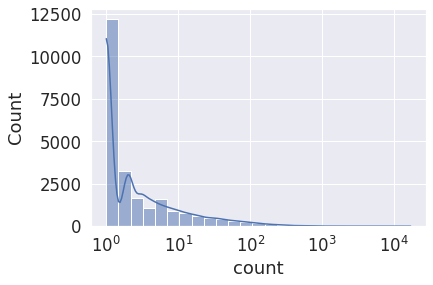

In [185]:
sns.histplot(data=tokens_df, x='count', kde=True, bins=25, log_scale=True)

Plot what percent of all words and what percent of entries in the training set are removed if we only include words which appear more than `n` times, for varying choices of `n`:

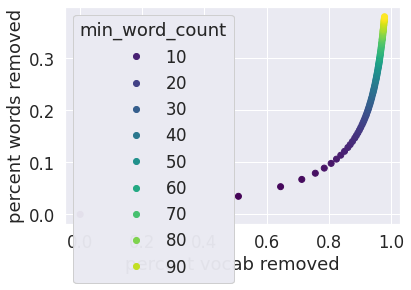

In [186]:
def vocab_words_removed(n, df):
    df = df.copy()
    filtered_df = df.loc[lambda x: x['count'] >= n]
    vocab_pct_removed = 1- len(filtered_df) / len(df)
    words_pct_removed = 1 - filtered_df['count'].sum() / df['count'].sum()
    return (vocab_pct_removed, words_pct_removed)

removed_data = [vocab_words_removed(n, tokens_df) for n in range(1, 100)]
fig, ax = plt.subplots(1, 1)
scatter = ax.scatter(*zip(*removed_data),
                     c=np.arange(1, len(removed_data) + 1),
                     cmap='viridis')
ax.set_xlabel('percent vocab removed')
ax.set_ylabel('percent words removed')
legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="upper left", 
                    title="min_word_count")
ax.add_artist(legend1)
fig.savefig(FOLDERNAME + '/figures/embedding_vocab_words_removed_plot.svg')

We can pass a `min_word_count` arg (default `1`) to the architecture and datamodules which will filter the vocab to only include words with `count >= min_word_count` `tokens_df`. (This filtering crucially assumes lower-indexed words have a higher count than higher-indexed ones).

In [187]:
MIN_WORD_COUNT = 1
print(vocab_words_removed(MIN_WORD_COUNT, tokens_df))

(0.0, 0.0)


Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [188]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Thu Jan 13 04:19:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    37W / 300W |   6133MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [189]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_recurrent_embedding_glove_pretrained


#Loading GloVe Models
We load in the result of first training a Glove model on the full text of the ~2million abstracts in the large training set and then fine tuning that results on the balanced title text.

In [190]:
GLOVE_PROJECT = 'large_abstract_glove_finetuning'
wandb_api = wandb.Api()
glove_runs = wandb_api.runs(ENTITY + "/" + GLOVE_PROJECT) 

run_cats = ('best_loss','config', 'name', 'wandb_path')
glove_runs_dict = {key: [] for key in run_cats}

for run in glove_runs:
    run_json = run.summary._json_dict
    if 'best_loss' in run_json:
        glove_runs_dict['best_loss'].append(run_json['best_loss'])
        glove_runs_dict['config'].append({key: val for key, val in run.config.items()})
        glove_runs_dict['name'].append(run.name)
        glove_runs_dict['wandb_path'].append('/'.join(run.path))
    
glove_runs_df = pd.DataFrame(glove_runs_dict).sort_values(by='best_loss', ascending=True).reset_index(drop=True)
glove_runs_df.head()

,best_loss,config,name,wandb_path
0,0.002331,"{'lr': 0.11805470596535687, 'alpha': 0.75, 'x_...",lr_0.11805470596535689,garrett361/large_abstract_glove_finetuning/3o8...


In [191]:
best_glove_df = glove_runs_df.iloc[glove_runs_df['best_loss'].argmin()]
print(best_glove_df)

best_loss                                              0.002331
config        {'lr': 0.11805470596535687, 'alpha': 0.75, 'x_...
name                                     lr_0.11805470596535689
wandb_path    garrett361/large_abstract_glove_finetuning/3o8...
Name: 0, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [194]:
# wandb stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_glove_df.config.items():
    if val == 'None':
        best_glove_df.config[key] = None
# Write to disk
glove_file_name = f"glove_dim_{best_glove_df.config['embedding_dim']}.pt"
wandb.restore(glove_file_name,
              run_path=best_glove_df.wandb_path,
              replace=True)
glove_file_name_suffix = '_'.join(glove_file_name.split('_')[-2:])
# Also copy to the final_models folder
!cp '{glove_file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + glove_file_name_suffix}"
co_matrix = torch.load(FOLDERNAME + SUBDIR + "balanced_title_co_matrix_context_2.pt")

In [196]:
# Need to restore the tokens arg which is not synced with wandb.
best_glove_model = avm.LitGloVe(**{**best_glove_df.config, **{'co_matrix': co_matrix}})
best_glove_model.load_state_dict(torch.load(glove_file_name))
best_glove_model_embedding_weights = best_glove_model.get_embedding_weights()

Rebuild the model, but now using the trained GloVe embedding:

In [197]:
model_args_dict = {'seq_len': SEQ_LEN,
                  'min_word_count': MIN_WORD_COUNT,
                  'tokens': tokens_df,
                  'num_layers': 2,
                  'hidden_size': 512,
                  'rnn_type': 'GRU',
                  'bidirectional': True,
                  'hidden_strategy': 'max',
                  'embedding_dim': best_glove_model.get_embedding_weights().shape[1],
                  'zero_fc_bias_init': True,
                  'lr_scheduler': 'plateau',
                  'lr_scheduler_args': {'verbose': True,
                                        'patience': 1,
                                        'factor': .1},
                   'embedding_from_pretrained': best_glove_model.get_embedding_weights(),
                   'freeze_pretrained': True
                  }
model = notebook_model(**model_args_dict)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



Test: `$` and `\` should have a large cosine:

In [198]:
model.get_embedding_cosine(text_to_idx['$'], text_to_idx['\\'])

tensor(0.7230)

# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [ ]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [ ]:
print(train_data_df.head().to_string())

In [ ]:
print(val_data_intersections_filtered_df.head().to_string())

# Layer-by-Layer Training

Following the advice of [1801.06146](https://arxiv.org/pdf/1801.06146.pdf), we gradually unfreeze the layers of the architecture while training.


# LR Finder

In [133]:
data_args_dict = {'seq_len': SEQ_LEN,
                  'min_word_count': MIN_WORD_COUNT,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'tokens': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'num_workers': NUM_PROCESSORS,
                 'batch_size': 64,
                 'pin_memory': IS_CUDA_AVAILABLE,
                 'persistent_workers': True
                 }

In [137]:
small_data_module = notebook_datamodule(**{**data_args_dict, **{'sample_size': .5}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, idx_to_text).strip()
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**{**model_args_dict, **{'save_models_to_wandb': False}})
print('Model layers:', small_model)
small_preds, small_losses, _ = small_model.scores_loss_hiddens(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', -np.log(.5))

text: the superhorizon test of future b - mode experiments
len: 52
source: False
text: quantum electrodynamics with a nonmoving dielectric sphere : quantizing mie scattering
len: 86
source: False
text: a modified greedy algorithm to improve bounds for the vertex cover number
len: 73
source: False
Model layers: LitEmbeddingRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.




preds shape: torch.Size([64])

actual loss: 0.6933382153511047

expected approx loss 0.6931471805599453


In [138]:
# pl implements gradient clipping through the Trainer.
small_trainer = Trainer(gpus=-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1,
                        gradient_clip_val=1
                        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_8436997d-ed3b-4652-9aa0-949924268e71.ckpt


Suggested lr: 0.008556365008514052


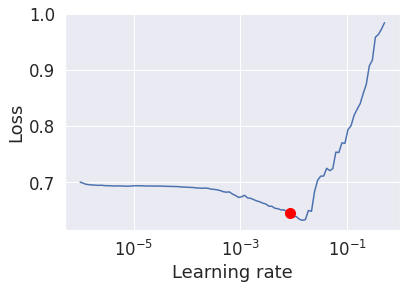

In [139]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, min_lr=1e-6, max_lr=5e-1)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: {small_trainer_suggested_lr}')

# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `sweep_fixed_model_args_dict`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `sweep_fixed_model_args_dict` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [140]:
sweep_fixed_model_args_dict = {**deepcopy(model_args_dict), 
                               **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': np.log(small_trainer_suggested_lr / 5).item(),
                                      'max': np.log(small_trainer_suggested_lr * 5).item()
                                      },
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `sweep_fixed_model_args_dict` for logging purposes.

In [141]:
# Setting 'batch_size' in sweep_data_args_dict controls the batch size, while setting
# this key in sweep_fixed_model_args_dict just lets wandb track this hyperparameter.
sweep_data_args_dict = deepcopy(data_args_dict)
sweep_data_args_dict['batch_size'] = sweep_fixed_model_args_dict['batch_size'] = 2048

# Set max_epochs in a dict, along with any other optional trainer kwargs.
sweep_trainer_dict = {'max_epochs': 32,
                      'gradient_clip_val': 5,
                      }

# Merge sweep_trainer_dict into sweep_fixed_model_args_dict for logging purposes.
sweep_fixed_model_args_dict = {**sweep_fixed_model_args_dict, **sweep_trainer_dict}

def sweep_val_examples(sample_size=512,
                       datamodule_args=sweep_data_args_dict):
    """Taking random samples from the validation set for callback visualization.
    """
    val_sample_module = notebook_datamodule(**{**datamodule_args,
                                               **{'sample_size': sample_size}})
    val_sample_module.setup()
    val_sample  = next(iter(val_sample_module.val_dataloader()))
    return val_sample

def sweep_trainer(model):
    """Encapsulating the trainer used for wandb sweeps.
    """
    trainer = Trainer(logger=WandbLogger(),
                      gpus=-1 if IS_CUDA_AVAILABLE else 0,
                      log_every_n_steps=5,
                      callbacks=[notebook_wandb_text_callback(val_sample=sweep_val_examples(),
                                                         decoder_fn=notebook_decoder,
                                                         decoder_dict=idx_to_text,
                                                         labels=('arxiv', 'vixra')),
                                 EarlyStopping(monitor='val_acc',
                                               mode='max',
                                               check_on_train_epoch_end=False,
                                               patience=5,
                                               verbose=True),
                                 notebook_wandb_embedding_callback(model=model,
                                                                   heatmap_words=heatmap_words,
                                                                   pca_words=pca_words,
                                                                   tsne_words=tsne_words,
                                                                   word_to_idx=text_to_idx,
                                                                   idx_to_word=idx_to_text,
                                                                   k=5,
                                                                   heatmap_title=f'{PROJECT} Cosine Heatmap',
                                                                   pca_title=f'{PROJECT} PCA',
                                                                   tsne_title=f'{PROJECT} t-SNE',
                                                    )
                                 ],
                      num_sanity_val_steps=-1,
                      **sweep_trainer_dict
                      )
    return trainer

def sweep_iteration():
    """The wandb sweep iteration function. To be passed to wandb.agent.
    """
    # There seems to be a 128 char limit on the group_str
    group_str = '-'.join(sorted([f'{key}_{val}' for key, val in sweep_fixed_model_args_dict.items() if key != 'tokens']))[:128]
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**sweep_data_args_dict)
        config = wandb.config
        # Overwrite the random run names chosen by wandb.
        run.name = '-'.join(sorted([f'{key}_{val}' for key, val in config.items()]))[:128]
        # Merge config into remaining parameters.
        config = {**sweep_fixed_model_args_dict, **config}
        model = notebook_model(**config)
        print(50 * '-',
              'Model Architecture:',
              model,
              50 * '-',
              sep='\n')
        trainer = sweep_trainer(model)
        trainer.fit(model, 
                    datamodule=data)

In [156]:
best_glove_model.word_embedding.weight.abs().mean()

tensor(0.3168, grad_fn=<MeanBackward0>)

In [160]:
best_glove_model.context_embedding.weight.abs().mean()

tensor(0.0011, grad_fn=<MeanBackward0>)

In [171]:
best_glove_model.word_embedding.weight.std()

tensor(0.4696, grad_fn=<StdBackward0>)

In [170]:
best_glove_model.word_embedding.weight.mean()

tensor(0.0020, grad_fn=<MeanBackward0>)

In [172]:
best_glove_model.context_embedding.weight.mean()

tensor(0.0011, grad_fn=<MeanBackward0>)

In [173]:
best_glove_model.context_embedding.weight.std()

tensor(0.4641, grad_fn=<StdBackward0>)

In [164]:
((best_glove_model.context_embedding.weight - best_glove_model.word_embedding.weight) ** 2).mean()

tensor(0.4032, grad_fn=<MeanBackward0>)

In [144]:
model.get_embedding_weights()

<bound method LitEmbeddingRecurrent.get_embedding_weights of LitEmbeddingRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)>

In [142]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: u8ql0uy0
Sweep URL: https://wandb.ai/garrett361/balanced_title_recurrent_embedding_glove_pretrained/sweeps/u8ql0uy0


In [143]:
wandb.agent(sweep_id, function=sweep_iteration, count=5)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: Agent Starting Run: 4a8i2vyk with config:
wandb: 	lr: 0.006231302852473419


--------------------------------------------------
Model Architecture:
LitEmbeddingRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

   | Name                    | Type             | Pa

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6928622722625732
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6928622722625732


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7096688151359558
Validation Loss: 0.5126392245292664
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7096688151359558
Validation Loss: 0.5126392245292664


Metric val_acc improved. New best score: 0.710
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.8008813858032227
Validation Loss: 0.43129390478134155
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.8008813858032227
Validation Loss: 0.43129390478134155


Metric val_acc improved by 0.091 >= min_delta = 0.0. New best score: 0.801
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.7980769276618958
Validation Loss: 0.4130220413208008


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8318642973899841
Validation Loss: 0.38057956099510193
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.8318642973899841
Validation Loss: 0.38057956099510193


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Metric val_acc improved by 0.031 >= min_delta = 0.0. New best score: 0.832
/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) 

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.838942289352417
Validation Loss: 0.38363784551620483


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 6
Validation accuracy: 0.8460202813148499
Validation Loss: 0.38372907042503357


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch     7: reducing learning rate of group 0 to 6.2313e-04.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch     9: reducing learning rate of group 0 to 6.2313e-05.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    11: reducing learning rate of group 0 to 6.2313e-06.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▆▆▆▇███████
best_val_loss,█▄▃▃▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
global_step,▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
train_acc,▁▅▆▆▆▇▇█████
train_auc_roc,▁▅▆▆▇▇▇█████
train_average_precision,▁▆▆▇▇▇██████
train_f1,▁▅▆▆▆▇▇█████
train_loss,█▄▄▃▃▂▂▁▁▁▁▁
train_precision,▁▅▆▆▇▇▇█████
train_recall,▁▅▆▆▆▇▇█████


wandb: Agent Starting Run: to48asnf with config:
wandb: 	lr: 0.010050096369426413


--------------------------------------------------
Model Architecture:
LitEmbeddingRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

   | Name                    | Type             | Pa

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.693433403968811
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.693433403968811


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.5084134340286255
Validation Loss: 0.6792410612106323
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.5084134340286255
Validation Loss: 0.6792410612106323


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7044604420661926
Validation Loss: 0.5920515060424805
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7044604420661926
Validation Loss: 0.5920515060424805


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.7724359035491943
Validation Loss: 0.47810181975364685
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.7724359035491943
Validation Loss: 0.47810181975364685


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.7883279919624329
Validation Loss: 0.5097159147262573


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8066239356994629
Validation Loss: 0.41711005568504333
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.8066239356994629
Validation Loss: 0.41711005568504333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.8183760643005371
Validation Loss: 0.4471103847026825


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 6
Validation accuracy: 0.8253205418586731
Validation Loss: 0.4196317195892334


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch     7: reducing learning rate of group 0 to 1.0050e-03.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 7
Validation accuracy: 0.8263888955116272
Validation Loss: 0.39852210879325867
Saved best val_loss at global step: 143
Epoch: 7
Validation accuracy: 0.8263888955116272
Validation Loss: 0.39852210879325867


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 8
Validation accuracy: 0.8310630321502686
Validation Loss: 0.3993944823741913


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 179
Epoch: 9
Validation accuracy: 0.8336004018783569
Validation Loss: 0.40353870391845703


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    10: reducing learning rate of group 0 to 1.0050e-04.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    12: reducing learning rate of group 0 to 1.0050e-05.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    14: reducing learning rate of group 0 to 1.0050e-06.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▅▇▇▇██████████
best_val_loss,█▆▃▃▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_acc,▁▃▅▆▇▇▇████████
train_auc_roc,▁▄▆▇▇▇▇████████
train_average_precision,▁▄▅▇▇▇▇████████
train_f1,▁▃▅▆▇▇▇████████
train_loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁
train_precision,▁▄▅▇▇▇▇████████
train_recall,▁▂▅▆▇▇▇████████


wandb: Agent Starting Run: 263ibzbo with config:
wandb: 	lr: 0.040413528145772835


--------------------------------------------------
Model Architecture:
LitEmbeddingRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

   | Name                    | Type             | Pa

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6925467252731323
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6925467252731323


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.5080128312110901
Validation Loss: 1.4753974676132202


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.5142895579338074
Validation Loss: 0.8074951171875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.6199252009391785
Validation Loss: 0.6124341487884521
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.6199252009391785
Validation Loss: 0.6124341487884521


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.6212607026100159
Validation Loss: 0.6021527051925659
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.6212607026100159
Validation Loss: 0.6021527051925659


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.7443910241127014
Validation Loss: 0.5784929394721985
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.7443910241127014
Validation Loss: 0.5784929394721985


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 107
Epoch: 5
Validation accuracy: 0.7080662250518799
Validation Loss: 0.5267817378044128


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 7
Validation accuracy: 0.7891292572021484
Validation Loss: 0.5073009133338928
Saved best val_loss at global step: 143
Epoch: 7
Validation accuracy: 0.7891292572021484
Validation Loss: 0.5073009133338928


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 8
Validation accuracy: 0.7978098392486572
Validation Loss: 0.43888646364212036
Saved best val_loss at global step: 161
Epoch: 8
Validation accuracy: 0.7978098392486572
Validation Loss: 0.43888646364212036


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 197
Epoch: 10
Validation accuracy: 0.8052884340286255
Validation Loss: 0.43506816029548645
Saved best val_loss at global step: 197
Epoch: 10
Validation accuracy: 0.8052884340286255
Validation Loss: 0.43506816029548645


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 215
Epoch: 11
Validation accuracy: 0.8138354420661926
Validation Loss: 0.43296897411346436
Saved best val_loss at global step: 215
Epoch: 11
Validation accuracy: 0.8138354420661926
Validation Loss: 0.43296897411346436


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 233
Epoch: 12
Validation accuracy: 0.8044871687889099
Validation Loss: 0.43069714307785034


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 251
Epoch: 13
Validation accuracy: 0.8133012652397156
Validation Loss: 0.421602725982666


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    16: reducing learning rate of group 0 to 4.0414e-03.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 305
Epoch: 16
Validation accuracy: 0.8154380321502686
Validation Loss: 0.44384506344795227


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 323
Epoch: 17
Validation accuracy: 0.819978654384613
Validation Loss: 0.42715156078338623


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    18: reducing learning rate of group 0 to 4.0414e-04.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 341
Epoch: 18
Validation accuracy: 0.8226495981216431
Validation Loss: 0.4295940697193146


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    20: reducing learning rate of group 0 to 4.0414e-05.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    22: reducing learning rate of group 0 to 4.0414e-06.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    24: reducing learning rate of group 0 to 4.0414e-07.


best_val_acc,▁▁▃▄▆▆▆▇▇▇██████████████
best_val_loss,██▆▆▅▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▂▄▄▅▆▅▆▆▆▇▇▇▇▇▇███████
train_auc_roc,▁▂▃▄▅▅▆▆▇▇▇▇▇▇█▇████████
train_average_precision,▁▂▃▄▅▅▆▆▇▇▇▇▇▇█▇████████
train_f1,▂▁▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇███████
train_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▂▃▅▅▅▆▅▇▇▇▇▇▇█▇████████
train_recall,▃▁▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇███████


wandb: Agent Starting Run: u8wkwsay with config:
wandb: 	lr: 0.023079232296751


--------------------------------------------------
Model Architecture:
LitEmbeddingRecurrent(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

   | Name                    | Type             | Pa

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6938350796699524
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6938350796699524


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.5126869678497314
Validation Loss: 0.7057871222496033


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6925907731056213


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.6419604420661926
Validation Loss: 0.6464307308197021
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.6419604420661926
Validation Loss: 0.6464307308197021


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.627136766910553
Validation Loss: 0.6005316972732544


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.7353098392486572
Validation Loss: 0.5174134969711304
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.7353098392486572
Validation Loss: 0.5174134969711304


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.7708333134651184
Validation Loss: 0.5220837593078613


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 125
Epoch: 6
Validation accuracy: 0.7294337749481201
Validation Loss: 0.5062657594680786


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 7
Validation accuracy: 0.7875267267227173
Validation Loss: 0.44591405987739563
Saved best val_loss at global step: 143
Epoch: 7
Validation accuracy: 0.7875267267227173
Validation Loss: 0.44591405987739563


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 179
Epoch: 9
Validation accuracy: 0.8030181527137756
Validation Loss: 0.48782646656036377


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    10: reducing learning rate of group 0 to 2.3079e-03.


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 197
Epoch: 10
Validation accuracy: 0.7907318472862244
Validation Loss: 0.43981435894966125


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 215
Epoch: 11
Validation accuracy: 0.80982905626297
Validation Loss: 0.4295874536037445
Saved best val_loss at global step: 215
Epoch: 11
Validation accuracy: 0.80982905626297
Validation Loss: 0.4295874536037445


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 233
Epoch: 12
Validation accuracy: 0.8112980723381042
Validation Loss: 0.4258190393447876
Saved best val_loss at global step: 233
Epoch: 12
Validation accuracy: 0.8112980723381042
Validation Loss: 0.4258190393447876


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

# Load the Best Models

Load all runs recorded in `wandb` for this notebook.

In [ ]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_val_acc',
            'best_val_loss',
            'config', 
            'name', 
            'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if {'best_val_acc','best_val_loss'}.issubset(run_json.keys()):
        if run.config['save_models_to_wandb']:
            notebook_runs_dict['best_val_acc'].append(run_json['best_val_acc'])
            notebook_runs_dict['best_val_loss'].append(run_json['best_val_loss'])
            notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
            notebook_runs_dict['name'].append(run.name)
            notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
notebook_runs_df.head()

,best_val_acc,best_val_loss,config,name,wandb_path
0,0.846554,0.382084,"{'lr': 0.005062486582446775, 'l2_reg': 0.01757...",fc_dropout_0.944669557689955-l2_reg_0.01757407...,garrett361/balanced_title_recurrent_embedding/...
1,0.845486,0.413877,"{'lr': 0.0008124659843814654, 'l2_reg': 0.7932...",fc_dropout_0.9521615747156527-l2_reg_0.7932406...,garrett361/balanced_title_recurrent_embedding/...
2,0.842281,0.388410,"{'lr': 0.0003342530193554, 'l2_reg': 0.0002526...",fc_dropout_0.5048804478214595-l2_reg_0.0002526...,garrett361/balanced_title_recurrent_embedding/...
3,0.842014,0.409435,"{'lr': 0.0013296833540471938, 'l2_reg': 0.1130...",fc_dropout_0.8873679263353795-l2_reg_0.1130499...,garrett361/balanced_title_recurrent_embedding/...
4,0.841880,0.381726,"{'lr': 0.000282511904115681, 'l2_reg': 0.01963...",fc_dropout_0.7736786673746117-l2_reg_0.0196322...,garrett361/balanced_title_recurrent_embedding/...


Isolate the best models by `val_acc` and `val_loss`:

In [ ]:
best_val_acc_model_df = notebook_runs_df.iloc[notebook_runs_df['best_val_acc'].argmax()]
print(best_val_acc_model_df)

best_val_acc                                              0.846554
best_val_loss                                             0.382084
config           {'lr': 0.005062486582446775, 'l2_reg': 0.01757...
name             fc_dropout_0.944669557689955-l2_reg_0.01757407...
wandb_path       garrett361/balanced_title_recurrent_embedding/...
Name: 0, dtype: object


In [ ]:
best_val_loss_model_df = notebook_runs_df.iloc[notebook_runs_df['best_val_loss'].argmin()]
print(best_val_loss_model_df)

best_val_acc                                              0.837073
best_val_loss                                             0.372638
config           {'lr': 0.0003996460789948324, 'l2_reg': 0, 'fc...
name                                      lr_0.0003996460789948324
wandb_path       garrett361/balanced_title_recurrent_embedding/...
Name: 57, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [ ]:
for file_name, model in (('model_best_val_acc.pt', best_val_acc_model_df),
                         ('model_best_val_loss.pt', best_val_loss_model_df),):
    model_path = model.wandb_path
    # wandb also stores None values in the config dict as a string literal. Need to
    # fix these entries, annoyingly.
    for key, val in model.config.items():
        if val == 'None':
            model.config[key] = None
    # Write to disk
    wandb.restore(file_name, run_path=model_path, replace=True)
    file_suffix = file_name.split('_')[-1]
    !cp '{file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + file_suffix}"

In [ ]:
# Need to restore the tokens arg which is not synced with wandb.
best_val_acc_model = notebook_model(**{**best_val_acc_model_df.config, **{'tokens': tokens_df}})
best_val_acc_model.load_state_dict(torch.load('model_best_val_acc.pt'))
best_val_loss_model = notebook_model(**{**best_val_loss_model_df.config, **{'tokens': tokens_df}})
best_val_loss_model.load_state_dict(torch.load('model_best_val_loss.pt'))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



<All keys matched successfully>

# My Papers

Finally, examine the model's results on my own papers:

In [ ]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
goon_papers_df

,title,source
0,"quantum corrections to generic branes : dbi , ...",arxiv
1,universal relation between corrections to entr...,arxiv
2,primordial non - gaussianity,arxiv
3,"superluminality , black holes and eft",arxiv
4,shapes of gravity : tensor non - gaussianity a...,arxiv
5,the effective theory of shift - symmetric cosm...,arxiv
6,partially massless fields during inflation,arxiv
7,soft theorems for shift - symmetric cosmologies,arxiv
8,heavy fields and gravity,arxiv
9,aspects of galileon non - renormalization,arxiv


Encode titles, stack into a tensor, and generate predictions:

In [ ]:
# Need to rebuild the word_to_idx mappings based on model specifics.
for model_type, model in (('best_val_acc_model', best_val_acc_model),
                          ('best_val_loss_model', best_val_loss_model)):
    model_min_word_count = model.hparams.min_word_count
    model_max_embedding_idx = (tokens_df['count'] >= model_min_word_count).sum() + 1
    model_word_to_idx = {text: idx for text, idx in text_to_idx.items() if idx <= model_max_embedding_idx}
    goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, model_word_to_idx, SEQ_LEN))], dim=0)
    model_probs_t = model.inference(goon_papers_t)
    goon_papers_df['vixra_prob_' + model_type] = model_probs_t
    print(f'Mean prediction of {model_type}: {model_probs_t.mean().item()}')
    print(f'Correct predictions from {model_type}: {(model_probs_t < .5).sum()}/{goon_papers_t.shape[0]}')

Mean prediction of best_val_acc_model: 0.2599080502986908
Correct predictions from best_val_acc_model: 15/20
Mean prediction of best_val_loss_model: 0.3990465998649597
Correct predictions from best_val_loss_model: 13/20


Visualized by title:

In [ ]:
goon_papers_df = goon_papers_df.sort_values(by='vixra_prob_best_val_acc_model', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df)

,title,source,vixra_prob_best_val_acc_model,vixra_prob_best_val_loss_model
0,"einstein gravity , massive gravity , multi - gravity and nonlinear realizations",arxiv,0.989960,0.972740
1,galileons as wess - zumino terms,arxiv,0.890615,0.732733
2,"superluminality , black holes and eft",arxiv,0.890231,0.601606
3,massive gravity coupled to galileons is ghost - free,arxiv,0.767902,0.582843
4,galileons coupled to massive gravity : general analysis and cosmological solutions,arxiv,0.695754,0.285897
5,symmetries for galileons and dbi scalars on curved space,arxiv,0.282837,0.146483
6,a new class of effective field theories from embedded branes,arxiv,0.279555,0.366412
7,universal relation between corrections to entropy and extremality,arxiv,0.200064,0.336123
8,shapes of gravity : tensor non - gaussianity and massive spin - 2 fields,arxiv,0.046536,0.373493
9,heavy fields and gravity,arxiv,0.032584,0.196061


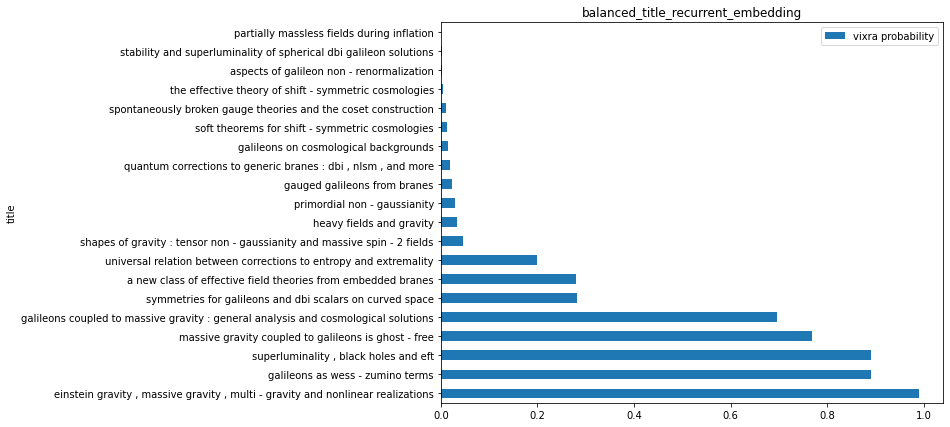

In [ ]:
goon_papers_df_barh = goon_papers_df.plot.barh(x='title',
                                               y='vixra_prob_best_val_acc_model', 
                                               title=PROJECT, 
                                               figsize=(9, 7),
                                               label='vixra probability',
                                               legend=True)
goon_papers_df_barh.figure.savefig(FOLDERNAME + f'/figures/{PROJECT}_goon_papers_preds.svg', bbox_inches='tight')

# Embedding Visualization

Compute the cosines bewteen all emedding vectors:

In [ ]:
best_val_acc_embedding = best_val_acc_model.embedding.weight.detach()
best_val_acc_embedding_inners = (best_val_acc_embedding @ best_val_acc_embedding.T)
# Add small constant to avoid dividing by zero due to padding zero vector.
best_val_acc_embedding_inners_norms = best_val_acc_embedding_inners.diag().sqrt() + 1e-10 
best_val_acc_embedding_inners_normalized = best_val_acc_embedding_inners / best_val_acc_embedding_inners_norms / best_val_acc_embedding_inners_norms[:, None]
torch.testing.assert_close(best_val_acc_embedding_inners_normalized.diagonal().sum(), torch.tensor(best_val_acc_embedding.shape[0] - 1.))

In [ ]:
best_val_acc_embedding_inners_normalized[15].topk(4).indices[1:]

tensor([ 356, 3421,  236])

In [ ]:
tokens_df.iloc[best_val_acc_embedding_inners_normalized[14].topk(10).indices[1:]]

,word,count
14712,powerfree,1
19552,superluminals,1
16076,ultrapower,1
15756,iphones,1
12187,upsets,1
12488,supercollider,1
3373,equilibria,10
13450,ethersupporting,1
19884,wielkiego,1
